<a href="https://colab.research.google.com/github/pavanbaloju/agrivision-semantic-segmentation/blob/main/Unet_efficientb4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!tar -xf drive/My\ Drive/Agriculture-Vision.tar

importing libraries

In [ ]:
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


defining datagenerators

In [ ]:
data_gen_args = dict(rescale = 1/255.,
                     rotation_range=90,
                     brightness_range=[0.2,1.0],
                     zoom_range=[0.5,1.0],
                     horizontal_flip = True,
                     vertical_flip = True,)
train_image_datagen = ImageDataGenerator(**data_gen_args, )
train_mask_datagen = ImageDataGenerator(**data_gen_args)
val_image_datagen = ImageDataGenerator(rescale = 1/255.)
val_mask_datagen = ImageDataGenerator(rescale = 1/255.)

loading data

In [ ]:
train_df = pd.read_csv("train_df.csv", index_col = [0])
val_df = pd.read_csv("val_df.csv", index_col=[0])
print(train_df.shape, val_df.shape)

(2338, 3) (1025, 3)


creating mask paths

In [ ]:
def func(f):
  return f[:-3]+"png"
train_mask_df = pd.DataFrame(train_df["image_name"].apply(func), columns=["image_name"])

In [ ]:
val_mask_df = pd.DataFrame(val_df["image_name"].apply(func), columns=["image_name"])

Creating train and mask generators of batchsize =8 and img_size = 256,256

In [ ]:
train_image_generator = train_image_datagen.flow_from_dataframe(
  train_df, directory = "Agriculture-Vision/train/images/rgb", x_col = "image_name", 
  batch_size = 8, seed = 1,class_mode = None
)
val_image_generator = val_image_datagen.flow_from_dataframe(
  val_df, directory = "Agriculture-Vision/val/images/rgb", x_col = "image_name", 
  batch_size = 8, seed = 2,class_mode = None
)
train_mask_generator = train_mask_datagen.flow_from_dataframe(
  train_mask_df, directory = "Agriculture-Vision/train/labels/weed_cluster", x_col = "image_name", 
  batch_size = 8, seed = 1, color_mode ="grayscale", class_mode = None
)
val_mask_generator = val_mask_datagen.flow_from_dataframe(
  val_mask_df, directory = "Agriculture-Vision/val/labels/weed_cluster", x_col = "image_name", 
  batch_size = 8, seed = 2, color_mode ="grayscale", class_mode = None
)

Found 2338 validated image filenames.
Found 1025 validated image filenames.
Found 2338 validated image filenames.
Found 1025 validated image filenames.


In [ ]:
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

In [ ]:
x = train_image_generator.next()
x.shape

(8, 256, 256, 3)

In [ ]:
y = train_mask_generator.next()
y.shape

(8, 256, 256, 1)

showing an image from trainset

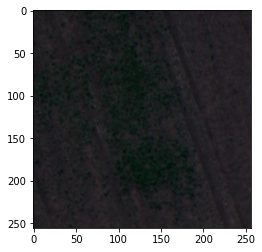

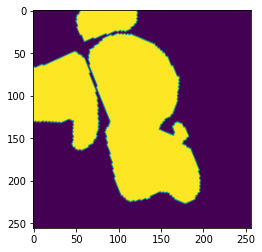

In [ ]:
index = np.random.randint(8)
plt.imshow(x[index,:,:,:])
plt.show()
plt.imshow(y[index,:,:,0])
plt.show()

In [ ]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-24wa3__h
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-24wa3__h
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=76084222862f26e8c431c9f949a3691860db1887245fa645a274dacf047d6517
  Stored in directory: /tmp/pip-ephem-wheel-cache-wc5b171g/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
import segmentation_models as sm
model = sm.Unet('efficientnetb4', encoder_weights='imagenet', classes =1, activation='sigmoid')

Defining Soft dice loss and callbacks

In [ ]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * K.sum(y_pred * y_true, axes)
    denominator = K.sum(K.square(y_pred) + K.square(y_true), axes)
    
    return 1 - K.mean((numerator + epsilon) / (denominator + epsilon))

metric = keras.metrics.MeanIoU(num_classes=1)
def dice_coef(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

  return (numerator + 1) / (denominator + 1)
def scheduler(epoch, lr):
  if epoch <5:
    return float(lr)
  else:
    return float(lr * tf.math.exp(-0.1))

callback = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
checkpoint2 = keras.callbacks.ModelCheckpoint(
    filepath = "best_weights_of_unet_dicecoef.hdf5",
    save_weights_only=True,
    monitor='dice_coef', 
    mode='max',
    save_best_only=True, verbose = 1)
early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=1)

compiling model

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss = [soft_dice_loss], metrics= [dice_coef])

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch= 500, epochs = 10,validation_data=val_generator,
                    validation_steps = 200, initial_epoch = 0, callbacks=[early_stopping, callback, checkpoint2])

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
500/500 [==============================] - 382s 763ms/step - loss: 0.2315 - dice_coef: 0.8064 - val_loss: 0.4005 - val_dice_coef: 0.8303

Epoch 00001: dice_coef improved from -inf to 0.80637, saving model to best_weights_of_unet_dicecoef.hdf5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0010000000474974513.
500/500 [==============================] - 332s 665ms/step - loss: 0.1913 - dice_coef: 0.8261 - val_loss: 0.3523 - val_dice_coef: 0.8198

Epoch 00002: dice_coef improved from 0.80637 to 0.82609, saving model to best_weights_of_unet_dicecoef.hdf5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0010000000474974513.
500/500 [==============================] - 332s 663ms/step - loss: 0.1811 - dice_coef: 0.8297 - val_loss: 0.3072 - val_dice_coef: 0.8429

Epoch 00003: dice_coef improved from 0.82609 to 0.82967, saving model to best_weights_of

extending training for 10 epochs

In [ ]:
history2 = model.fit_generator(train_generator, steps_per_epoch= 500, epochs = 20,validation_data=val_generator,
                    validation_steps = 200, initial_epoch = 10, callbacks=[early_stopping, callback, checkpoint2])

Epoch 11/20

Epoch 00011: LearningRateScheduler setting learning rate to 0.0005488114547915757.
500/500 [==============================] - 330s 661ms/step - loss: 0.1589 - dice_coef: 0.8396 - val_loss: 0.3004 - val_dice_coef: 0.8547

Epoch 00011: dice_coef improved from 0.83909 to 0.83964, saving model to best_weights_of_unet_dicecoef.hdf5
Epoch 12/20

Epoch 00012: LearningRateScheduler setting learning rate to 0.0004965850966982543.
500/500 [==============================] - 331s 662ms/step - loss: 0.1562 - dice_coef: 0.8411 - val_loss: 0.3125 - val_dice_coef: 0.8588

Epoch 00012: dice_coef improved from 0.83964 to 0.84115, saving model to best_weights_of_unet_dicecoef.hdf5
Epoch 13/20

Epoch 00013: LearningRateScheduler setting learning rate to 0.0004493287415243685.
500/500 [==============================] - 331s 662ms/step - loss: 0.1514 - dice_coef: 0.8421 - val_loss: 0.2401 - val_dice_coef: 0.8569

Epoch 00013: dice_coef improved from 0.84115 to 0.84213, saving model to best_weig

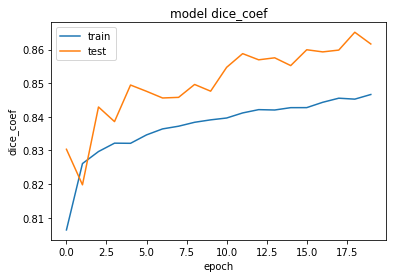

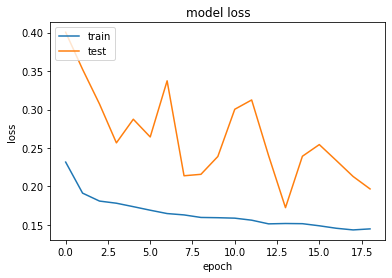

In [ ]:
losses = []
val_losses = []
iou = []
val_iou = []
for his in [history, history2]:
    losses = losses + his.history["loss"]
    val_losses = val_losses + his.history["val_loss"]
    iou = iou + his.history["dice_coef"]
    val_iou = val_iou + his.history["val_dice_coef"]

plt.plot(iou)
plt.plot(val_iou)
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(losses[:-1])
plt.plot(val_losses[:-1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
x = train_image_generator.next()
y = train_mask_generator.next()

In [ ]:
pred = (model.predict(x)>0.5).astype(int)

Plotting predictions vs true mask

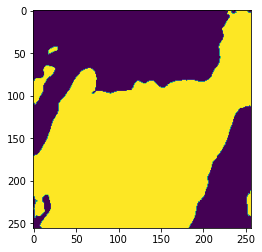

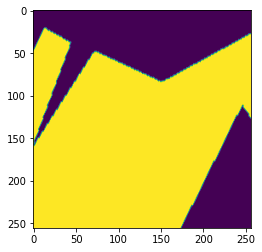

In [ ]:
ind = 0
plt.imshow(pred[ind,:,:,0])
plt.show()
plt.imshow(y[ind,:,:,0])
plt.show()

In [ ]:
x = train_image_generator.next()
y = train_mask_generator.next()
preds = (model.predict(x)>0.5).astype(int)

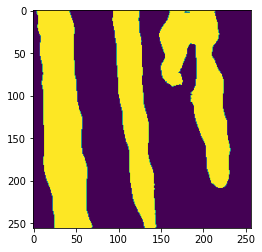

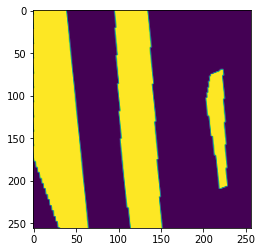

In [ ]:
ind = 4
plt.imshow(preds[ind,:,:,0])
plt.show()
plt.imshow(y[ind,:,:,0])
plt.show()

loss and mean_iou of train_set

In [ ]:
model.evaluate_generator(train_generator, steps = 8, verbose = 1)

8/8 [==============================] - 2s 285ms/step


[0.1521679162979126, 0.8477504253387451]

loss and iou of val set

In [ ]:
model.evaluate_generator(val_generator, steps = 8, verbose = 1)

8/8 [==============================] - 1s 142ms/step


[0.23835551738739014, 0.8661646842956543]

Predicting random test image

(256, 256, 3)


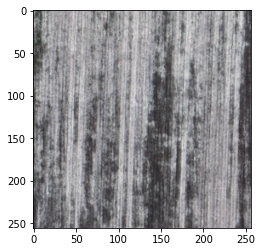

(1, 256, 256, 3)


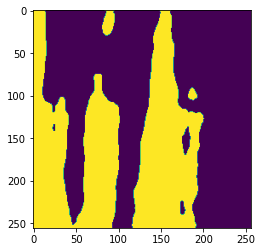

In [ ]:
import os
import cv2
test_paths = sorted(os.listdir("Agriculture-Vision/test/images/rgb"))
index = np.random.randint(len(test_paths))
img = cv2.resize(cv2.imread(os.path.join("Agriculture-Vision/test/images/rgb", test_paths[index])), (256,256))
print(img.shape)
plt.imshow(img)
plt.show()
img = np.expand_dims(np.array(img), axis = 0)
print(img.shape)
plt.imshow((model.predict(img/255.)>0.5).astype(int)[0,:,:,0], )
plt.show()